# Model: ARIMA, Stock Token: FPT, Train/Test/Validation/: 80/10/10
- Dataset: 1313 rows x 7 columns (01/03/2019 - 31/05/2024)
----
### Model evaluation (Test set)
- RMSE: 70059.33
- MAE: 69964.48
- MAPE: 7.94 %

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error,
)
import joblib
from sklearn.preprocessing import MinMaxScaler

from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

plt.style.use("default")

## 1. Data preprocessing

In [2]:
stocks = ["FPT", "CMG", "ITD"]  # Stock token in dataset
targets = ["close"]  # The closing price is the target we want to predict
train_test_split = ["721", "622", "811"]  # Percent of for train, test, validation

project_path = os.getcwd()
data_path = os.path.join(project_path, "data\\")
project_path_optimize = os.path.join(project_path, "optimize\\")
processing_output = os.path.join(project_path, "processing_output\\")

os.makedirs(processing_output, exist_ok=True)

T = 60  # ----> lookback
TF = 1  # ----> predict
NFeature = 1  # ----> feautures

data_set = {1: "train", 2: "test", 3: "validation"}
stock_id = 0
# n_split = 0  # 721
# n_split = 1  # 622
n_split = 2  # 811

In [3]:
def getData(index):
    df = pd.read_csv(f"../../Dataset/{stocks[index]}_stock.csv", index_col="time")

    return df[[targets[0]]]

In [4]:
df = getData(stock_id)
df.head()

,close
time,
2019-03-01,19270
2019-03-04,19440
2019-03-05,19390
2019-03-06,19270
2019-03-07,19330


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1313 entries, 2019-03-01 to 2024-05-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   close   1313 non-null   int64
dtypes: int64(1)
memory usage: 20.5+ KB


In [6]:
df.describe()

,close
count,1313.000000
mean,56880.086824
std,27473.981127
min,19190.000000
25%,28410.000000
50%,63470.000000
75%,71450.000000
max,138000.000000


In [7]:
df.isna().sum()

close    0
dtype: int64

Preprocess

In [8]:
def normalizationMinMax(df, data_set_index):
    """
    Params:
        * df -- DataFrame:        Dataframe need to be scaled
        * data_set_index -- int:  A number to recognize that dataset is train/testvalidation
    Returns:
        * scaler:     used for future inverse-transform
        * df_scaled:  df after normalization

    """
    scaler = MinMaxScaler()
    norm_set = data_set[data_set_index]

    processes_folder = f"{processing_output}/{stocks[stock_id]}"
    os.makedirs(processes_folder, exist_ok=True)

    if norm_set == "train":
        scaler.fit(df)
        series = scaler.transform(df)
        # neu du lieu la tap train, ham se tien hanh fit() va transform() dua tren tap train
        df_scaled = pd.DataFrame(data=series, columns=df.columns)
        out_scaler_file = os.path.join(
            processing_output,
            f"{stocks[stock_id]}\{train_test_split[n_split]}\{targets[0]}_{norm_set}_scalerMinMaxNorm.save",
        )
        os.makedirs(os.path.dirname(out_scaler_file), exist_ok=True)
        joblib.dump(scaler, out_scaler_file)
        # sau do luu lai scaler de su dung cho cac tap test va validation
        print(os.path.exists(out_scaler_file))

    else:
        # neu du lieu la tap test hoac validation, ham se su dung scaler da duoc fit() tu tap train
        scaler = joblib.load(
            os.path.join(
                processing_output,
                f"{stocks[stock_id]}\{train_test_split[n_split]}\{targets[0]}_train_scalerMinMaxNorm.save",
            )
        )
        series = scaler.transform(df)
        df_scaled = pd.DataFrame(data=series, columns=df.columns)

    out_file = os.path.join(
        processing_output,
        f"{stocks[stock_id]}\{train_test_split[n_split]}\{targets[0]}_{norm_set}_scaler.xlsx",
    )

    df_scaled.to_excel(out_file, float_format="%.5f")
    print(out_file)
    return df_scaled, scaler

<string>:24: SyntaxWarning: invalid escape sequence '\{'
<string>:24: SyntaxWarning: invalid escape sequence '\{'
<string>:36: SyntaxWarning: invalid escape sequence '\{'
<string>:36: SyntaxWarning: invalid escape sequence '\{'
<string>:44: SyntaxWarning: invalid escape sequence '\{'
<string>:44: SyntaxWarning: invalid escape sequence '\{'
<>:24: SyntaxWarning: invalid escape sequence '\{'
<>:24: SyntaxWarning: invalid escape sequence '\{'
<>:36: SyntaxWarning: invalid escape sequence '\{'
<>:36: SyntaxWarning: invalid escape sequence '\{'
<>:44: SyntaxWarning: invalid escape sequence '\{'
<>:44: SyntaxWarning: invalid escape sequence '\{'
<string>:24: SyntaxWarning: invalid escape sequence '\{'
<string>:24: SyntaxWarning: invalid escape sequence '\{'
<string>:36: SyntaxWarning: invalid escape sequence '\{'
<string>:36: SyntaxWarning: invalid escape sequence '\{'
<string>:44: SyntaxWarning: invalid escape sequence '\{'
<string>:44: SyntaxWarning: invalid escape sequence '\{'
<>:24: Syn

## 2. Train model

In [9]:
n_observations = df.shape[0]

train_ratio = 0.7
test_ratio = 0.2

train_size = int(n_observations * train_ratio)
test_size = int(n_observations * test_ratio)
val_size = n_observations - train_size - test_size

train = df[:train_size]
test = df[train_size : train_size + test_size]
val = df[-val_size:]

In [10]:
# MinMaxScaler
train_scaled, scaler = normalizationMinMax(train, 1)
test_scaled, scaler = normalizationMinMax(test, 2)
val_scaled, scaler = normalizationMinMax(val, 3)
train_scaled.head()

True


d:\hocTap\nam3\hk2\phanTichData\IS403_O22_HTCL_8\Model\ARIMA\processing_output\FPT\811\close_train_scaler.xlsx
d:\hocTap\nam3\hk2\phanTichData\IS403_O22_HTCL_8\Model\ARIMA\processing_output\FPT\811\close_test_scaler.xlsx
d:\hocTap\nam3\hk2\phanTichData\IS403_O22_HTCL_8\Model\ARIMA\processing_output\FPT\811\close_validation_scaler.xlsx


,close
0,0.001297
1,0.004054
2,0.003243
3,0.001297
4,0.002270


ARIMA

In [11]:
#load scaler
scaler = joblib.load(os.path.join(f"{processing_output}/{stocks[stock_id]}/{train_test_split[n_split]}", f"{targets[0]}_train_scalerMinMaxNorm.save"))

In [12]:
def getDataExcel(subset="train"):
    df = pd.read_excel(
        f"./processing_output/{stocks[stock_id]}/{train_test_split[n_split]}/{targets[0]}_{subset}_scaler.xlsx"
    )
    df.drop(columns=["Unnamed: 0"], inplace=True)
    return df

Model

In [13]:
def buildModel(df):
    arimaModel = pm.auto_arima(
        df,
        test="adf",  # use adftest to find optimal 'd'
        trace=True,
        max_p=10,
        max_q=10,
        error_action="ignore",
        suppress_warnings=True,
        seasonal=False,
        n_fits=100,
        alpha=0.01,
        maxiter=50,
        stepwise=False,
    )
    return arimaModel

In [14]:
df_train = getDataExcel(subset="train")
df_test = getDataExcel(subset="test")
df_val = getDataExcel(subset="validation")

In [15]:
model = buildModel(df_train)
print(model.summary())

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-5119.348, Time=0.03 sec


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5117.526, Time=0.21 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-5123.389, Time=0.39 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-5122.294, Time=0.41 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=-5121.188, Time=0.62 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=-5120.373, Time=0.76 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-5117.500, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-5115.377, Time=0.42 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-5121.968, Time=0.47 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-5119.809, Time=0.15 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=-5119.259, Time=0.75 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-5123.735, Time=0.18 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-5122.241, Time=0.37 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-5120.057, Time=0.24 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-5118.107, Time=0.37 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-5122.231, Time=0.25

## 2. Model evaluation

In [16]:
def evaluate(df, title, actual, predict):
    rmse = np.sqrt(mean_squared_error(actual, predict))
    mae = mean_absolute_error(actual, predict)
    mape = mean_absolute_percentage_error(actual, predict) * 100

    df[f"rmse_{title}"].append(rmse)
    df[f"mae_{title}"].append(mae)
    df[f"mape_{title}"].append(mape)
    return df

In [17]:
metrics_df = {
    "rmse_train": [],
    "mae_train": [],
    "mape_train": [],
    "rmse_test": [],
    "mae_test": [],
    "mape_test": [],
    "rmse_val": [],
    "mae_val": [],
    "mape_val": [],
}

# Dự đoán trên tập huấn luyện
y_pred_train = model.predict_in_sample()
# inverse transform TRAIN (tra ve kieu truoc khi scale)
pred_train = scaler.inverse_transform(np.array(y_pred_train).reshape(1, -1))
y_actual_train = scaler.inverse_transform(df_train)

# Dự đoán trên tập kiểm thử
y_pred_test = model.predict(n_periods=len(df_test))
# inverse transform TEST (tra ve kieu truoc khi scale)
pred_test = scaler.inverse_transform(np.array(y_pred_test).reshape(1, -1))
y_actual_test = scaler.inverse_transform(df_test)

# cap nhat model voi tap test
model.update(df_test)

# Du doan tren tap validation
y_pred_val = model.predict(n_periods=len(df_val))
# inverse transform VAL
pred_val = scaler.inverse_transform(np.array(y_pred_val).reshape(1, -1))
y_actual_val = scaler.inverse_transform(df_val)


metrics_df = evaluate(metrics_df, "train", df_train.close.values, pred_train.squeeze())
metrics_df = evaluate(metrics_df, "test", df_test.close.values, pred_test.squeeze())
metrics_df = evaluate(metrics_df, "val", df_val.close.values, pred_val.squeeze())

metrics_df = pd.DataFrame(metrics_df)
metrics_folder = f"metrics\{stocks[stock_id]}"
os.makedirs(metrics_folder, exist_ok=True)
metrics_df.to_excel(f"{metrics_folder}\ARIMA_{train_test_split[n_split]}.xlsx")

print("------------------ Evaluation model ---------------------")
metrics_df

<string>:40: SyntaxWarning: invalid escape sequence '\{'
<>:40: SyntaxWarning: invalid escape sequence '\{'
<>:42: SyntaxWarning: invalid escape sequence '\A'
<string>:40: SyntaxWarning: invalid escape sequence '\{'
<>:40: SyntaxWarning: invalid escape sequence '\{'
<>:42: SyntaxWarning: invalid escape sequence '\A'
C:\Users\Admin\AppData\Local\Temp\ipykernel_23364\2563623432.py:40: SyntaxWarning: invalid escape sequence '\{'
  metrics_folder = f"metrics\{stocks[stock_id]}"
C:\Users\Admin\AppData\Local\Temp\ipykernel_23364\2563623432.py:42: SyntaxWarning: invalid escape sequence '\A'
  metrics_df.to_excel(f"{metrics_folder}\ARIMA_{train_test_split[n_split]}.xlsx")


------------------ Evaluation model ---------------------


<string>:40: SyntaxWarning: invalid escape sequence '\{'


,rmse_train,mae_train,mape_train,rmse_test,mae_test,mape_test,rmse_val,mae_val,mape_val
0,48462.284136,44324.487787,9.563945e+18,70059.32765,69964.481453,7.938567e+06,96476.477546,96447.877774,6.814934e+06


In [18]:
y_actual_train

array([[19270.171 ],
       [19439.7635],
       [19389.8108],
       [19270.171 ],
       [19329.9909],
       [19289.9054],
       [19230.0855],
       [20089.7653],
       [19960.2583],
       [19989.8599],
       [19880.0873],
       [19960.2583],
       [19749.9636],
       [19629.7071],
       [19479.849 ],
       [19450.2474],
       [19190.    ],
       [19329.9909],
       [19439.7635],
       [19500.2001],
       [19650.0582],
       [19790.0491],
       [19880.0873],
       [20390.0982],
       [20660.2128],
       [20660.2128],
       [20660.2128],
       [20430.1837],
       [20250.1073],
       [20300.06  ],
       [20829.8053],
       [20700.2983],
       [20950.0618],
       [20950.0618],
       [20929.7107],
       [20700.2983],
       [20700.2983],
       [20959.929 ],
       [21080.1855],
       [21410.12  ],
       [21540.2437],
       [21600.0636],
       [21049.9672],
       [21469.9399],
       [21450.2055],
       [20990.1473],
       [21159.7398],
       [21389

In [19]:
pred_train

array([[19238.17925327, 19318.35025327, 19489.52724347, 19425.07749532,
        19325.25583662, 19394.24641427, 19335.71997888, 19285.08956866,
        20159.77772826, 19928.96521523, 20054.61911845, 19927.77103699,
        20023.86913134, 19791.41692671, 19699.98421365, 19541.16718174,
        19516.09011489, 19241.14652067, 19408.72205157, 19480.11864941,
        19542.71517618, 19698.52815392, 19829.90054523, 19920.16049193,
        20440.90752323, 20667.77941966, 20686.66329319, 20712.27128023,
        20478.95561332, 20321.40063319, 20369.90417646, 20884.69685276,
        20700.28437748, 21017.96660662, 20978.44166208, 20981.47841157,
        20751.00839338, 20774.10602949, 21015.69698335, 21109.3480889 ,
        21455.49164074, 21562.88217513, 21640.64049612, 21088.4949402 ,
        21580.15021355, 21462.16686482, 21037.50354958, 21257.83678232,
        21429.03587308, 21724.64360567, 21795.00392499, 21490.09043821,
        21633.94050065, 21978.0128145 , 22270.68199226, 21947.13

## 3. Predict the closing price in next 30/60/90 days

In [20]:
# Predict for the next 30 days
y_pred_future_30 = model.predict(n_periods=30)
# inverse transform FUTURE (return to the type before scaling)
pred_future_30 = scaler.inverse_transform(np.array(y_pred_future_30).reshape(1, -1))

# Predict for the next 60 days
y_pred_future_60 = model.predict(n_periods=60)
# inverse transform FUTURE (return to the type before scaling)
pred_future_60 = scaler.inverse_transform(np.array(y_pred_future_60).reshape(1, -1))

# Predict for the next 90 days
y_pred_future_90 = model.predict(n_periods=90)
# inverse transform FUTURE (return to the type before scaling)
pred_future_90 = scaler.inverse_transform(np.array(y_pred_future_90).reshape(1, -1))

In [21]:
pred_future_30

array([[92394.50045811, 92470.33622862, 92535.96427208, 92596.84222888,
        92658.25264273, 92719.93879775, 92781.59746381, 92843.24015805,
        92904.88425374, 92966.52927263, 93028.17422118, 93089.81911648,
        93151.46401524, 93213.10891706, 93274.75381871, 93336.39872019,
        93398.04362168, 93459.68852318, 93521.33342468, 93582.97832617,
        93644.62322767, 93706.26812917, 93767.91303067, 93829.55793216,
        93891.20283366, 93952.84773516, 94014.49263665, 94076.13753815,
        94137.78243965, 94199.42734115]])

### Plotting the data

In [22]:
train_range = range(0, len(y_actual_train.squeeze()))
test_range = range(
    train_range[-1] + 1, train_range[-1] + 1 + len(y_actual_test.squeeze())
)
val_range = range(test_range[-1] + 1, test_range[-1] + 1 + len(y_actual_val.squeeze()))

future_range_30 = range(
    val_range[-1] + 1, val_range[-1] + 1 + len(pred_future_30.squeeze())
)
future_range_60 = range(
    val_range[-1] + 1, val_range[-1] + 1 + len(pred_future_60.squeeze())
)
future_range_90 = range(
    val_range[-1] + 1, val_range[-1] + 1 + len(pred_future_90.squeeze())
)

In [23]:
def draw_plot(fureture_days, days):
    plt.figure(figsize=(16, 9))

    # Plot train data
    plt.plot(
        [*train_range],
        y_actual_train.squeeze(),
        label="Actual Train",
    )
    plt.plot(
        [*train_range],
        pred_train.squeeze(),
        label="Predict Train",
        linestyle="dotted",
    )

    # Plot test data
    plt.plot([*test_range], y_actual_test.squeeze(), label="Actual Test")
    plt.plot(
        [*test_range],
        pred_test.squeeze(),
        label="Predict Test",
        linestyle="dotted",
    )

    # Plot validation data
    plt.plot(
        [*val_range],
        y_actual_val.squeeze(),
        label="Actual Validation",
    )
    plt.plot(
        [*val_range],
        pred_val.squeeze(),
        label="Predict Validation",
        linestyle="dotted",
    )

    # Next xx days
    future_range = range(
        val_range[-1] + 1, val_range[-1] + 1 + len(fureture_days.squeeze())
    )
    plt.plot(
        [*future_range],
        fureture_days.squeeze(),
        label=f"Next {days} days",
        linestyle="dotted",
    )

    plt.legend()
    plt.title(f"ARIMA {stocks[stock_id]} -- {train_test_split[n_split]}")
    plt.show()

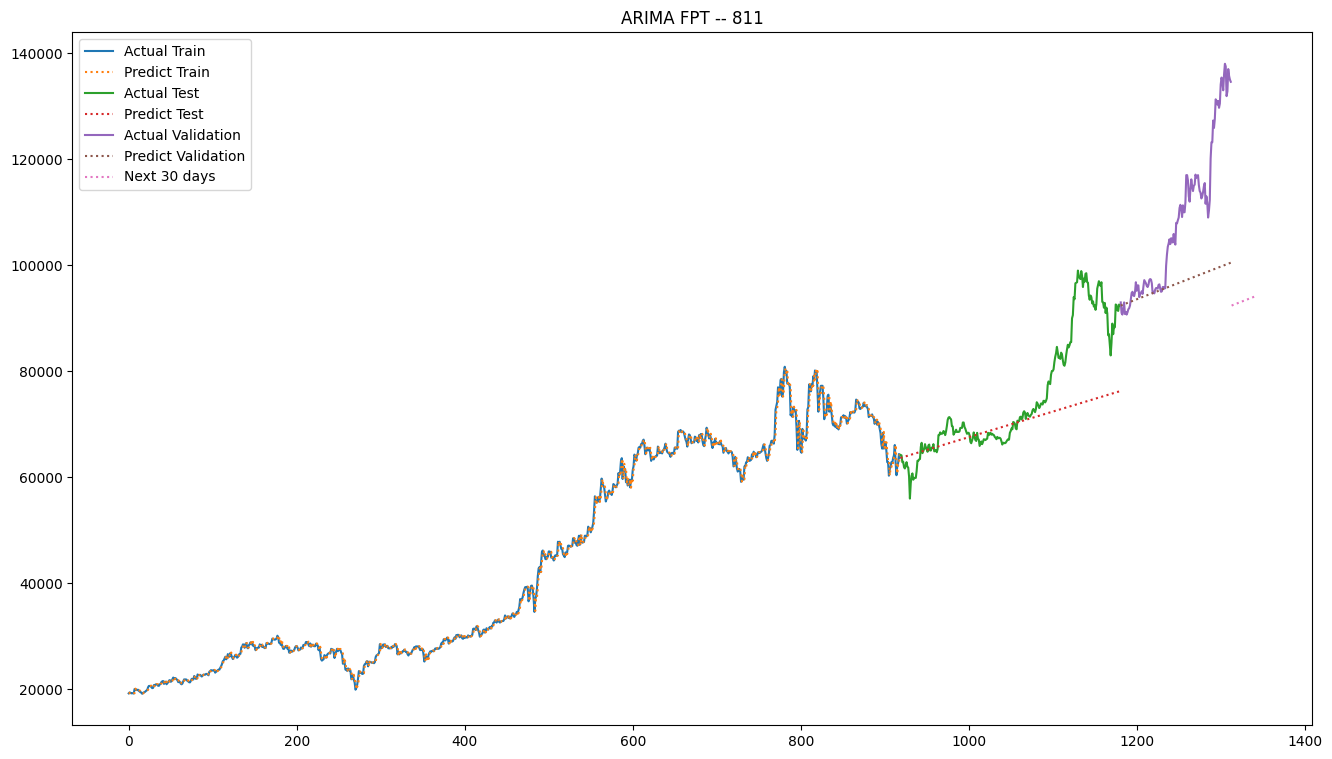

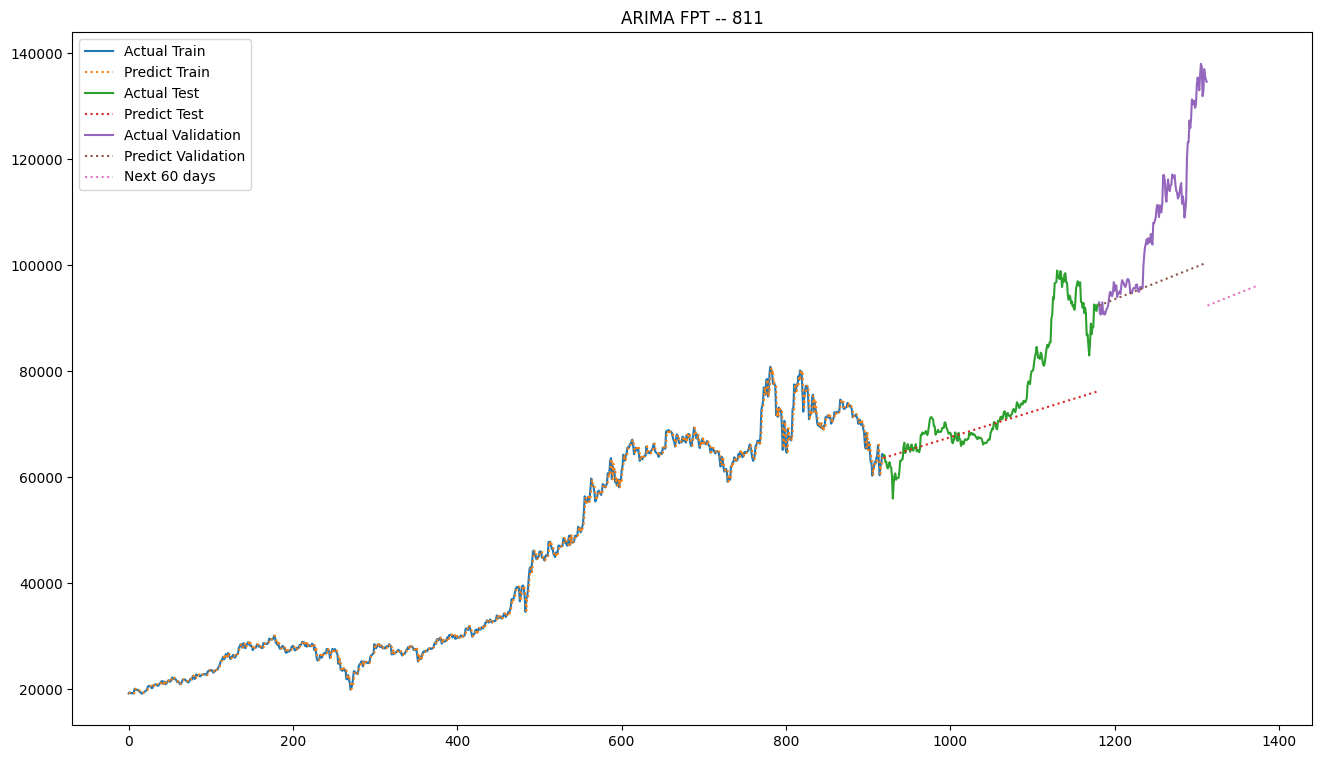

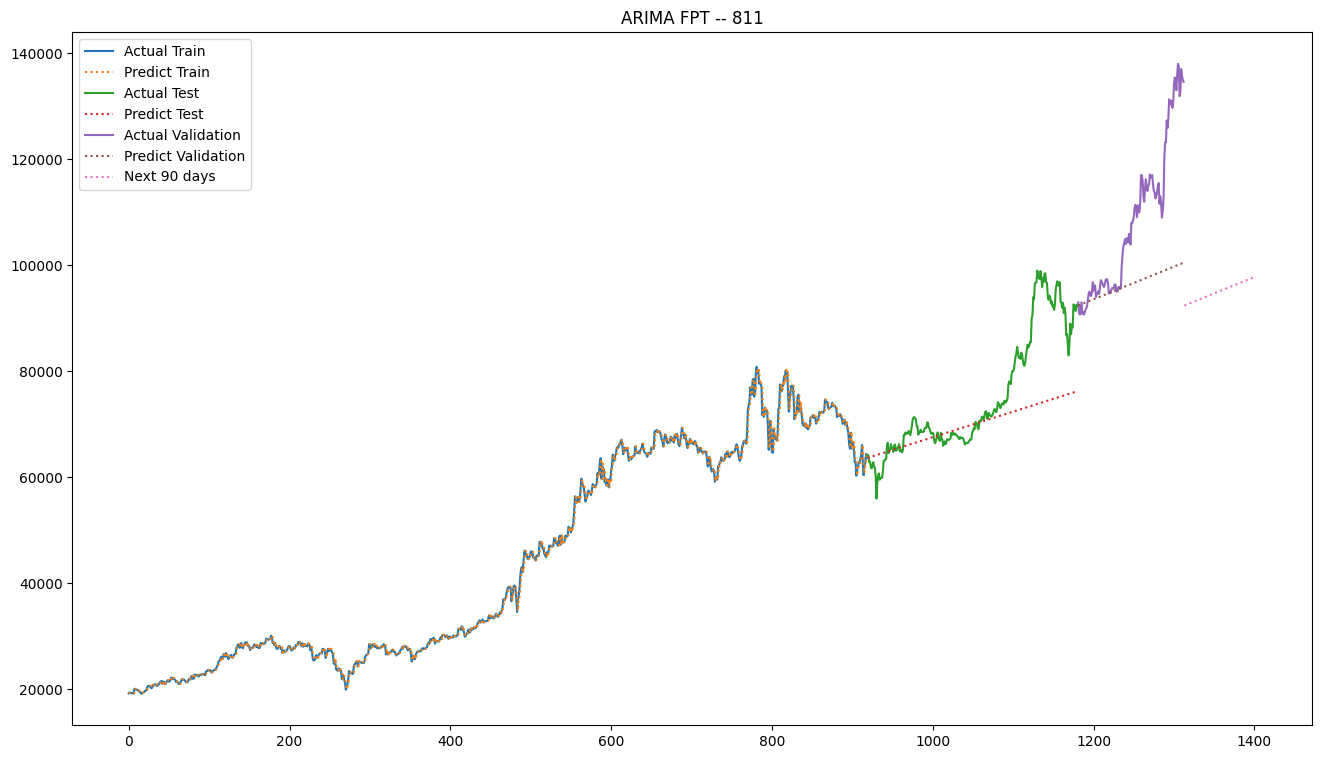

In [24]:
draw_plot(pred_future_30, 30)
draw_plot(pred_future_60, 60)
draw_plot(pred_future_90, 90)